In [1]:
#Importing modules
from scipy.io import arff
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Importing data
data_train = arff.loadarff('Earthquakes_TRAIN.arff')
df_train = pd.DataFrame(data_train[0])
label_train = df_train.loc[:,"target"].to_numpy().astype(int)

data_test = arff.loadarff('Earthquakes_TEST.arff')
df_test = pd.DataFrame(data_test[0])
label_test = df_test.loc[:,"target"].to_numpy().astype(int)

In [3]:
#defining the data arrays to work with
fdata = []
flabel = []

for i in range(len(label_train)):
    egi = df_train.iloc[i].to_numpy()[:-1]
    egi = egi.tolist()
    fdata.append(egi)
    flabel.append(label_train[i])
    
for i in range(len(label_test)):
    egi = df_test.iloc[i].to_numpy()[:-1]
    egi = egi.tolist()
    fdata.append(egi)
    flabel.append(label_test[i])
    
fdata = np.array(fdata)
flabel = np.array(flabel)

In [4]:
#code to find the similarity  using fastdtw and store the similarity matrix in a file

data_train = arff.loadarff('Earthquakes_TRAIN.arff')
df_train = pd.DataFrame(data_train[0])
label_train = df_train.loc[:,"target"].to_numpy().astype(int)

data_test = arff.loadarff('Earthquakes_TEST.arff')
df_test = pd.DataFrame(data_test[0])
label_test = df_test.loc[:,"target"].to_numpy().astype(int)

fdata = []
flabel = []

for i in range(len(label_train)):
    egi = df_train.iloc[i].to_numpy()[:-1]
    egi = egi.tolist()
    fdata.append(egi)
    flabel.append(label_train[i])
    
for i in range(len(label_test)):
    egi = df_test.iloc[i].to_numpy()[:-1]
    egi = egi.tolist()
    fdata.append(egi)
    flabel.append(label_test[i])
    
fdata = np.array(fdata)
flabel = np.array(flabel)

di = len(fdata)


sim_matrix = np.zeros((di,di))

for i in range(di):
    for j in range(i,di):

        eg_i = fdata[i]
        eg_i_class = flabel[i]


        eg_j = fdata[j]
        eg_j_class = flabel[j]
        
        distance, _ = fastdtw(eg_i, eg_j)
        sim = 1/(1+distance)
        
        sim_matrix[i][j] = sim
        sim_matrix[j][i] = sim
    print(i)
np.savetxt("full_dtw1.txt", sim_matrix, delimiter=" ",newline="\n")

KeyboardInterrupt: 

In [5]:
#importing the similarity matrix
dtwsim= np.loadtxt("full_dtw1.txt")
dtwsim_arr = []
for i in range(len(dtwsim)):
    for j in range(i,len(dtwsim)):
        dtwsim_arr.append(dtwsim[i][j])

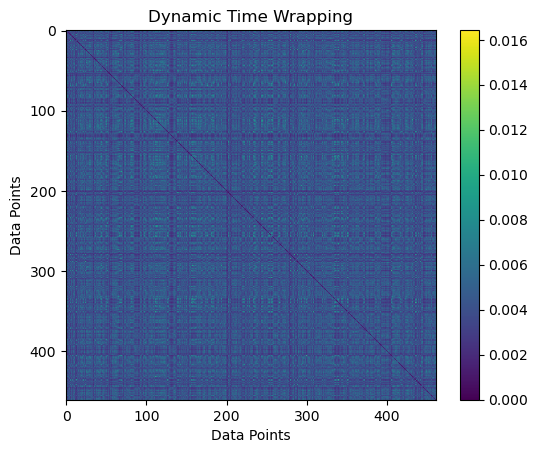

In [56]:
#visulaizing the similarity matrix
plt.imshow(np.where(dtwsim < 0.02, dtwsim, 0))
plt.xlabel("Data Points")
plt.ylabel("Data Points")
plt.title("Dynamic Time Wrapping")
plt.colorbar()

In [6]:
#defining the colors of the nodes
fcolors = []
for i in flabel:
    if i == 1:
        fcolors.append("red")
    else:
        fcolors.append("blue")

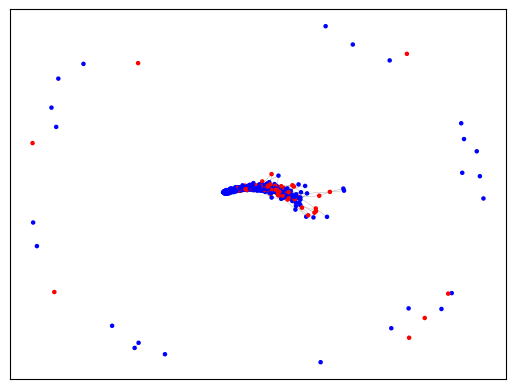

In [7]:
#plotting the network graph
threshold = 0.006
G = nx.Graph()

for i in range(len(fdata)):
    G.add_node(i)
    
for i in range(len(fdata)):
    for j in range(i+1,len(fdata)):
        #if np.corrcoef(fdata[i],fdata[j])[0][1] > threshold:
        if dtwsim[i][j] > threshold:
            G.add_edge(*(i,j))

nx.draw_networkx(G,pos=nx.spring_layout(G),node_size=5,with_labels=False,width=0.1,node_color=fcolors)
plt.savefig("eathquake_network_sparse.png",dpi = 600)
plt.show()

In [75]:
print("Edges: ", len(G.edges))
print("Nodes:" ,len(G.nodes))
print("Average Clustering: ",nx.average_clustering(G))
print("Density: ", nx.density(G))
print("transitivity: ",nx.transitivity(G))
a = np.array(list((nx.degree_centrality(G).values()))).astype("float64")
print("Degree centrality: ", "Mean-", np.mean(a*460), "Max-", np.max(a*460))

Edges:  11555
Nodes: 461
Average Clustering:  0.40121685573800664
Density:  0.10897859096482128
transitivity:  0.5634968478410217
Degree centrality:  Mean- 50.130151843817785 Max- 114.0


Diameter (Large component):  8


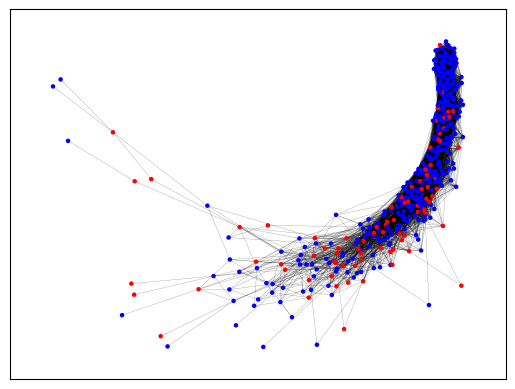

In [8]:
#plotting the largest component
G.to_undirected()

connectcmpnt = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
G = G.subgraph(connectcmpnt) 

fcolors1 = [fcolors[i] for i in G.nodes()]
flabel1 = [flabel[i] for i in G.nodes()]
nx.draw_networkx(G,pos=nx.spring_layout(G),node_size=5,with_labels=False,width=0.1,node_color=fcolors1)
plt.savefig("earthquake_largecomp.png",dpi=600)

print("Diameter (Large component): ",nx.diameter(G))
#plt.show()

In [11]:
#getting the relations between the clustering coefficient, diameter,sparseness vs threshold
clstr_arr = []
d_arr = []
sparse_arr = []

t_arr =np.arange(0.0005,0.01,0.0002)

for threshold in t_arr:
    print(threshold)
    G = nx.Graph()

    for i in range(len(fdata)):
        G.add_node(i)

    for i in range(len(fdata)):
        for j in range(i+1,len(fdata)):
            if dtwsim[i][j] > threshold:
                G.add_edge(*(i,j))
    
    clstr_arr.append(nx.average_clustering(G))
    
    G.to_undirected()
    connectcmpnt = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
    if nx.is_connected(G)==True:
        D = nx.diameter(G)
    else:
        largestconnectcmpnt = G.subgraph(connectcmpnt)
        D = nx.diameter(largestconnectcmpnt)
    
    d_arr.append(D)
    
    S = len(G.edges())/106030 
    sparse_arr.append(S)

0.0005


KeyboardInterrupt: 

In [ ]:
plt.plot(t_arr,clstr_arr)

In [ ]:
plt.plot(t_arr,d_arr)

In [ ]:
plt.plot(t_arr,sparse_arr)

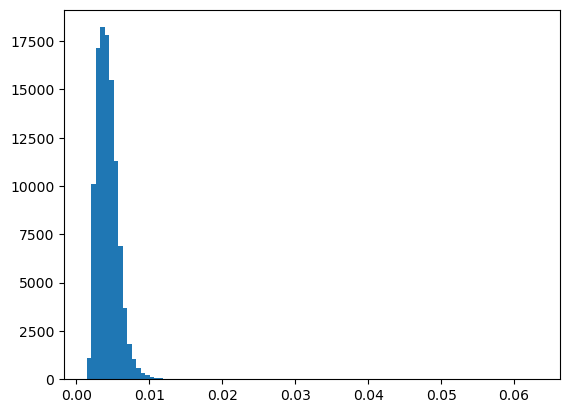

In [69]:
dtwsim_arr2 = []
for i in range(len(dtwsim)):
    for j in range(i+1,len(dtwsim)):
        dtwsim_arr2.append(dtwsim[i][j])
plt.hist(dtwsim_arr2,bins=100)
plt.show()

In [12]:
#true labels
nodes_c1 = []
nodes_c2 = []
for i in range(len(flabel1)):
    if flabel1[i] == 0:
        nodes_c1.append(i)
    else:
        nodes_c2.append(i)

In [9]:
#clustering and obtained the community labels
print(len(G.edges))
c = list(nx.community.greedy_modularity_communities(G,best_n = 2))


c1 = list(c[0])
c2 = list(c[1])

print(len(c1),len(c2))

11553
281 149


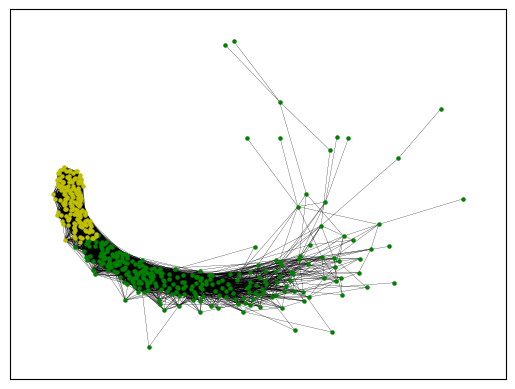

In [10]:
#plotting the clustered network
fclstrnodes = c1+c2

edge_list = list(G.edges())
G3= nx.Graph()
for n in fclstrnodes:
    G3.add_node(n)

for from_loc, to_loc in edge_list:
    G3.add_edge(from_loc, to_loc)

colors_c1 = [fcolors[i] for i in c1]
colors_c1 = [fcolors[i] for i in c2]


pos = nx.spring_layout(G3) 
nx.draw_networkx(G3, pos, nodelist=c1, node_color='g',node_size=5,with_labels=False,width=0.1)
nx.draw_networkx(G3, pos, nodelist=c2, node_color='y',node_size=5,with_labels=False,width=0.1)
plt.savefig("clustering_earthquake.png",dpi=600)
plt.show()

In [13]:
#obtaining the classification rate
print("Classificatoin rate: ", (len(set.intersection(set(c1),set(nodes_c1))) + len(set.intersection(set(c2),set(nodes_c2))))/430)


Classificatoin rate:  0.5581395348837209
